In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

In [3]:
from denoise import laloux
from srinkage_linear import ledoit_wolf_lin
from srinkage_nonlinear import ledoit_wolf_nonlin
from srinkage_quadratic import ledoit_wolf_quad

# Test eigen-function behaviour

In [4]:
# Design of Monte Carlo experiments is based on the one described in López de Prado (2020), Mashine Learning for Asset Managers

In [5]:
def eigh_decompose(matrix):
    """
        Return the eigenvalues and eigenvectors in a sorted order """
    
    eigenVal, eigenVec = np.linalg.eigh(matrix)
    indices = eigenVal.argsort()[::-1]
    eigenVal, eigenVec = eigenVal[indices], eigenVec[:,indices]
    eigenVal = np.diagflat(eigenVal)    
    return eigenVal, eigenVec

## Case 1: random covariance matrix

In [6]:
# generate random matrix
# T / N = 10
X = np.random.normal(size=(500, 100)) 

In [7]:
T, N = X.shape 
X -= np.mean(X, axis=0)
sample = X.T @ X / T
# cov_sample = sample.copy()

In [8]:
l = laloux(sample, T)
lw1 = ledoit_wolf_lin(X, d=True)
lw2 = ledoit_wolf_nonlin(sample, T)
lw3 = ledoit_wolf_quad(sample, T)

In [9]:
eigenVal0, eigenVec0 = eigh_decompose(sample)
eigenVal_l, eigenVec_l = eigh_decompose(l)
eigenVal_lw1, eigenVec_lw1 = eigh_decompose(lw1)
eigenVal_lw2, eigenVec_lw2 = eigh_decompose(lw2)
eigenVal_lw3, eigenVec_lw3 = eigh_decompose(lw3)

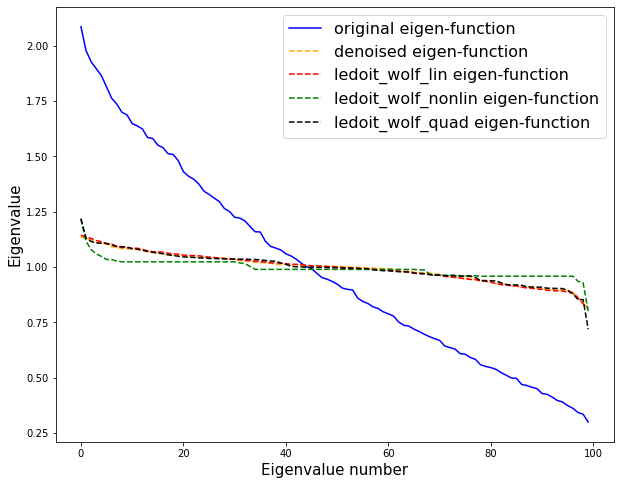

In [10]:
plt.figure(figsize=(10, 8))
plt.ylabel('Eigenvalue', fontsize=15)
plt.xlabel('Eigenvalue number', fontsize=15)

ax1 = pd.Series((np.diag(eigenVal0))).plot(color='blue',  label='original eigen-function')
pd.Series((np.diag(eigenVal_l))).plot(color='orange', linestyle='dashed', label='denoised eigen-function')
pd.Series((np.diag(eigenVal_lw1))).plot(color='red', linestyle='dashed', label='ledoit_wolf_lin eigen-function')
pd.Series((np.diag(eigenVal_lw2))).plot(color='green', linestyle='dashed', label='ledoit_wolf_nonlin eigen-function')
pd.Series((np.diag(eigenVal_lw3))).plot(color='black', linestyle='dashed', label='ledoit_wolf_quad eigen-function')

ax1.get_legend_handles_labels()

plt.legend(loc=1, prop={'size': 16})
plt.show()

## Case 2: non-random covariance matrix

In [11]:
"""
In an empirical correlation matrix, not all eigenvectors may be random.
Code below builds a covariance matrix that is not perfectly random and hence its eigenvalues will only approximately follow the Marcenko–Pastur PDF.
Out of the nCols random variables that form the covariance matrix generated by getRndCov, only nFacts contain some signal. 
To further dilute the signal, add that covariance matrix to a purely random matrix, with a weight alpha."""

def getRndCov(nCols, nFacts): 
    w = np.random.normal(size=(nCols,nFacts))
    cov = np.dot(w,w.T) # random cov matrix, however not full rank 
    cov += np.diag(np.random.uniform(size=nCols)) # full rank cov 
    return cov

alpha, nCols, nFact, q = .993, 100, 50, 10
# T / N = 10
T = nCols*q

# Form 'true' covariance matrix
cov = np.cov(np.random.normal(size=(int(T), nCols)),rowvar=0)
cov0 = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact) # noise + signal 

In [12]:
# without loss of generality, the variances are drawn from a uniform distribution bounded between 5% and 20%
std0 = np.random.uniform(.05, .2, nCols) 
# The vector of means is drawn from a Normal distribution with mean and standard deviation equal to the standard deviation from the 'true' covariance matrix.
# This is consistent with the notion that in an efficient market all securities have the same expected Sharpe ratio. 
mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
X = np.random.multivariate_normal(mu0.flatten(), cov0, size=1000) 

In [13]:
T, N = X.shape 
X -= np.mean(X, axis=0)
sample = X.T @ X / T

In [24]:
l = laloux(sample, T)
lw1 = ledoit_wolf_lin(X, d=True)
lw2 = ledoit_wolf_nonlin(sample, T)
lw3 = ledoit_wolf_quad(sample, T)

In [25]:
eigenVal0, eigenVec0 = eigh_decompose(sample)
eigenVal_l, eigenVec_l = eigh_decompose(l)
eigenVal_lw1, eigenVec_lw1 = eigh_decompose(lw1)
eigenVal_lw2, eigenVec_lw2 = eigh_decompose(lw2)
eigenVal_lw3, eigenVec_lw3 = eigh_decompose(lw3)

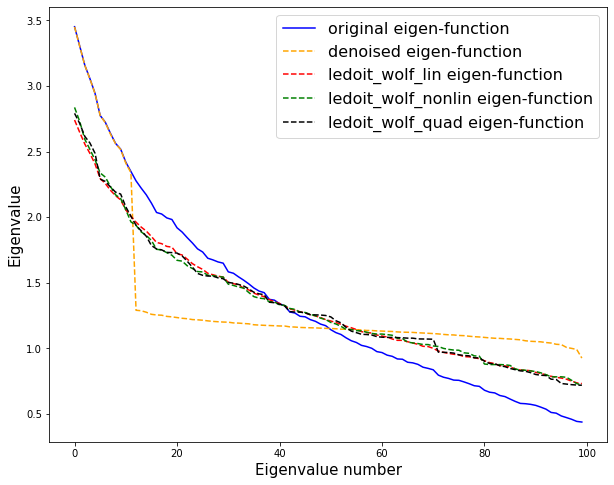

In [26]:
plt.figure(figsize=(10, 8))
plt.ylabel('Eigenvalue', fontsize=15)
plt.xlabel('Eigenvalue number', fontsize=15)

ax1 = pd.Series((np.diag(eigenVal0))).plot(color='blue',  label='original eigen-function')
pd.Series((np.diag(eigenVal_l))).plot(color='orange', linestyle='dashed', label='denoised eigen-function')
pd.Series((np.diag(eigenVal_lw1))).plot(color='red', linestyle='dashed', label='ledoit_wolf_lin eigen-function')
pd.Series((np.diag(eigenVal_lw2))).plot(color='green', linestyle='dashed', label='ledoit_wolf_nonlin eigen-function')
pd.Series((np.diag(eigenVal_lw3))).plot(color='black', linestyle='dashed', label='ledoit_wolf_quad eigen-function')

ax1.get_legend_handles_labels()

plt.legend(loc=1, prop={'size': 16})
plt.show()